In [2]:
from os import listdir
from os.path import isfile, join
import sys
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import csv

from tqdm import tqdm
from utils import Person, analyze, load_all_emg, find_trigger, create_frame, kfold, norm_frame
import pickle as pkl

from jAER_utils.converter import aedat2numpy

import cv2
from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
from numpy import array

In [3]:
# general stuff
fs = 200  # sampling frequency of MYO
VERBOSE = True
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/'
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']
classes_dict = {'pinky': 0, 'elle': 1, 'yo': 2, 'index': 3, 'thumb': 4}
classes_inv = {v: k for k, v in classes_dict.items()}

# Loading EMG

In [7]:
subjects = load_all_emg(data_dir=data_dir, classes=classes)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/'

# Loading DVS

In [ ]:
for subject, data in sorted(subjects.items()):
    
    if subject not in ["subject04_session03", "subject09_session02", "subject02_session03"]: # problematic sessions
    
        # loading dvs events 
        events = aedat2numpy(data_dir + subject +'_dvs.aedat')
        events = events[:, find_trigger(events[2]):]
        events[2] = events[2] / 1e3
        
        # loading davis events / frames
        davis_data = np.load(data_dir + f"{subject}_davis.npz")
        davis_frames = davis_data['frames']
        davis_times = davis_data['frames_time']
        davis_events = davis_data['dvs_events']

        for gesture in classes:
            for trial in range(5):
                if VERBOSE:
                    print("{} :: {} :: {}".format(subject, gesture, trial))

                # load beginning and end of trials
                b = np.array(data.begs[gesture][trial]) / fs
                e = np.array(data.ends[gesture][trial]) / fs

                # we extract all the events, we will frame them in 200ms later
                frame_size = 2
                beginning = b
                ending = beginning + frame_size

                # slice dvs
                sl = (events[2] > beginning) & (events[2] < ending)
                img_dvs = events[:, sl]
                
                # slice davis
                sl = (davis_events[2] > beginning) & (davis_events[2] < ending)
                sl2 = (davis_times > beginning) & (davis_times < ending)
                times = davis_times[sl2]
                imgs = davis_frames[sl2]
                frames_davis = imgs[:][::-1, :][:, ::-1]
                img_davis = davis_events[:, sl]

                beg_int = 0
                end_int = int(frame_size * fs)

                #### CROP DVS
                sll = (img_dvs[1] > 20) & (img_dvs[1] < 110) & (img_dvs[0] > 20) & (img_dvs[0] < 110)

                _frame = create_frame(img_dvs[1][sll], img_dvs[0][sll])

                # calculate center
                M = cv2.moments(_frame)
                x = int(M["m10"] / M["m00"])
                y = int(M["m01"] / M["m00"])

                # extract patch
                a = (img_dvs[0] > (x - 30)) & (img_dvs[0] < (x + 30))
                b = (img_dvs[1] > (127 - y - 30)) & (img_dvs[1] < (127 - y + 30))

                xx = img_dvs[0][a & b]
                yy = img_dvs[1][a & b]
                ts = img_dvs[2][a & b]
                pol = img_dvs[3][a & b]

                # saving
                data.x[gesture].append(xx - min(xx))
                data.y[gesture].append(yy - min(yy))
                data.ts[gesture].append(ts - min(ts))
                data.pol[gesture].append(pol)
                
                #### END CROP DVS
                
                #### CROP DAVIS
                sll = (img_davis[1] > 10) & (img_davis[1] < 170) & (img_davis[0] > 10) & (img_davis[0] < 230)

                _frame = create_frame(img_davis[1][sll], img_davis[0][sll], dim=(180, 240))

                M = cv2.moments(_frame)
                x = int(M["m10"] / M["m00"])
                y = int(M["m01"] / M["m00"])
                
                # extract patch
                a = (img_davis[0] > (240 - x - 60)) & (img_davis[0] < (240 - x + 60))
                b = (img_davis[1] > (180 - y - 60)) & (img_davis[1] < (180 - y + 60))
#                 b = (img_davis[1] > (y - 60)) & (img_davis[1] < (y + 60))

                xx = img_davis[0][a & b]
                yy = img_davis[1][a & b]
                ts = img_davis[2][a & b]
                pol = img_davis[3][a & b]
                
                xx = 240 - xx

                # saving
                data.x_davis[gesture].append(xx - min(xx))
                data.y_davis[gesture].append(yy - min(yy))
                data.ts_davis[gesture].append(ts - min(ts))
                data.pol_davis[gesture].append(pol)

                y = max(y, 60)
                _x = frames_davis[:, y - 60: y + 60, x - 60:x + 60]
                _x = norm_frame(_x)
                _ts = np.array(times - times[0])

                data.frames[gesture].append(_x)
                data.ts_frames[gesture].append(_ts)
                
                #### END CROP DAVIS

In [ ]:
# saving them for posterity
pkl.dump(subjects, open("all_subjects_crop_v5.pkl", "wb"))

In [9]:
# load - no need to run the above stuff
subjects = pkl.load(open("data/all_subjects_crop_v5.pkl", "rb"))

5
[[  58.  -10. -100. ...   27.  -70.   -5.]
 [  78.   24.   46. ...  -25.  -89.   -5.]
 [ -20.   -2.   17. ...  -42.   23.   11.]
 ...
 [  13.    7.   -1. ...   -6.    6.   -1.]
 [   1.  -17.    7. ...    3.   -4.    3.]
 [ -13.   13.   -8. ...   -7.    7.    0.]]
127.0
-128.0


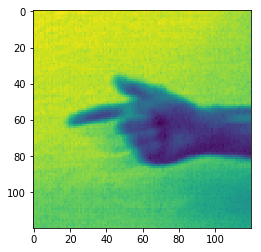

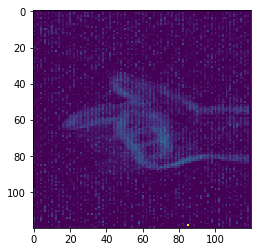

In [13]:
d = subjects['subject08_session01']
g = 'elle'
idx = 1
print(len(d.frames[g]))
plt.imshow(np.mean(d.frames[g][idx], 0))

xxx = d.x_davis[g][idx]
yyy = d.y_davis[g][idx]

kkk = create_frame(yyy, xxx, dim=(120, 120))
plt.figure()
plt.imshow(kkk)

print(d.trials[g][idx])
print(np.max(d.trials[g][idx]))
print(np.min(d.trials[g][idx]))

# Extract both in frames of YYYms

In [15]:
frame_len = 0.20
frame_len_samples = int(frame_len * fs)
bias = 0.00
bias_samples = int(bias * fs)
EMG, DVS, LBL, FRM, DAV = [], [], [], [], []

for subject, sub in sorted(subjects.items()):
    if subject not in ["subject04_session03", "subject09_session02", "subject02_session03"]:
        for gesture in classes:
            for trial in range(len(sub.y[gesture])):
                if VERBOSE:
                    print("{} :: {} :: {}".format(subject, gesture, trial))
                _emg = sub.trials[gesture][trial]

                # pad in case is shorter
                if _emg.shape[0] < 400:
                    _emg = np.vstack([_emg, np.zeros((400 - _emg.shape[0], 8))])
                # get rid of the first 200ms
                _emg = _emg[bias_samples:400]
                EMG.append(_emg.reshape(-1, frame_len_samples, 8))

                _x = sub.y[gesture][trial]
                _y = sub.x[gesture][trial]
                _ts = sub.ts[gesture][trial]
                _p = sub.pol[gesture][trial]

                _x_frame = sub.frames[gesture][trial]
                _ts_frame = sub.ts_frames[gesture][trial]
                _ts_davis = sub.ts_davis[gesture][trial]
                _x_davis = sub.y_davis[gesture][trial]
                _y_davis = sub.x_davis[gesture][trial]
                
                for i in np.arange(bias, 2.0, frame_len):
                    fil = (_ts_frame > i) & (_ts_frame < i + frame_len)
                    if len(_x_frame[fil].shape) > 1:
                        frame = np.uint8(np.mean(_x_frame[fil], 0))
                        sub_frame = cv2.resize(frame, (60, 60))
                        FRM.append(sub_frame)
                        
                        fil = (_ts_davis > i) & (_ts_davis < i + frame_len)
                        _frame = create_frame(_x_davis[fil], _y_davis[fil], dim=(120, 120))
                        sub_frame = cv2.resize(_frame, (60, 60))
                        DAV.append(sub_frame)
                    else: 
                        continue

                    fil = (_ts > i) & (_ts < i + frame_len)
                    _frame = create_frame(_x[fil], _y[fil], dim=(60, 60))
                    DVS.append(_frame)
                    LBL.append(classes_dict[gesture])

                
DVS = np.array(DVS)
DAV = np.array(DAV)
FRM = np.array(FRM)
EMG = np.array(EMG).reshape(-1, frame_len_samples, 8)
LBL = np.array(LBL).reshape(-1, 1)

print(np.array(DVS).shape)
print(np.array(DAV).shape)
print(np.array(FRM).shape)
print(np.array(EMG).shape)
print(np.array(LBL).shape)

subject01_session01 :: pinky :: 0
subject01_session01 :: pinky :: 1
subject01_session01 :: pinky :: 2
subject01_session01 :: pinky :: 3
subject01_session01 :: pinky :: 4
subject01_session01 :: elle :: 0
subject01_session01 :: elle :: 1
subject01_session01 :: elle :: 2
subject01_session01 :: elle :: 3
subject01_session01 :: elle :: 4
subject01_session01 :: yo :: 0
subject01_session01 :: yo :: 1
subject01_session01 :: yo :: 2
subject01_session01 :: yo :: 3
subject01_session01 :: yo :: 4
subject01_session01 :: index :: 0
subject01_session01 :: index :: 1
subject01_session01 :: index :: 2
subject01_session01 :: index :: 3
subject01_session01 :: index :: 4
subject01_session01 :: thumb :: 0
subject01_session01 :: thumb :: 1
subject01_session01 :: thumb :: 2
subject01_session01 :: thumb :: 3
subject01_session01 :: thumb :: 4
subject01_session02 :: pinky :: 0
subject01_session02 :: pinky :: 1
subject01_session02 :: pinky :: 2
subject01_session02 :: pinky :: 3
subject01_session02 :: pinky :: 4


subject04_session02 :: thumb :: 2
subject04_session02 :: thumb :: 3
subject04_session02 :: thumb :: 4
subject05_session01 :: pinky :: 0
subject05_session01 :: pinky :: 1
subject05_session01 :: pinky :: 2
subject05_session01 :: pinky :: 3
subject05_session01 :: pinky :: 4
subject05_session01 :: elle :: 0
subject05_session01 :: elle :: 1
subject05_session01 :: elle :: 2
subject05_session01 :: elle :: 3
subject05_session01 :: elle :: 4
subject05_session01 :: yo :: 0
subject05_session01 :: yo :: 1
subject05_session01 :: yo :: 2
subject05_session01 :: yo :: 3
subject05_session01 :: yo :: 4
subject05_session01 :: index :: 0
subject05_session01 :: index :: 1
subject05_session01 :: index :: 2
subject05_session01 :: index :: 3
subject05_session01 :: index :: 4
subject05_session01 :: thumb :: 0
subject05_session01 :: thumb :: 1
subject05_session01 :: thumb :: 2
subject05_session01 :: thumb :: 3
subject05_session01 :: thumb :: 4
subject05_session02 :: pinky :: 0
subject05_session02 :: pinky :: 1


subject08_session01 :: index :: 4
subject08_session01 :: thumb :: 0
subject08_session01 :: thumb :: 1
subject08_session01 :: thumb :: 2
subject08_session01 :: thumb :: 3
subject08_session01 :: thumb :: 4
subject08_session02 :: pinky :: 0
subject08_session02 :: pinky :: 1
subject08_session02 :: pinky :: 2
subject08_session02 :: pinky :: 3
subject08_session02 :: pinky :: 4
subject08_session02 :: elle :: 0
subject08_session02 :: elle :: 1
subject08_session02 :: elle :: 2
subject08_session02 :: elle :: 3
subject08_session02 :: elle :: 4
subject08_session02 :: yo :: 0
subject08_session02 :: yo :: 1
subject08_session02 :: yo :: 2
subject08_session02 :: yo :: 3
subject08_session02 :: yo :: 4
subject08_session02 :: index :: 0
subject08_session02 :: index :: 1
subject08_session02 :: index :: 2
subject08_session02 :: index :: 3
subject08_session02 :: index :: 4
subject08_session02 :: thumb :: 0
subject08_session02 :: thumb :: 1
subject08_session02 :: thumb :: 2
subject08_session02 :: thumb :: 3


In [20]:
print(np.min(EMG))
print(np.max(EMG))

-128.0
127.0


# Extract HOG features for DVS frames

In [ ]:
fig, ax = plt.subplots(1, 3)
idx = 1228
ax[0].imshow(DVS[idx])
ax[1].imshow(DAV[idx])
ax[2].imshow(FRM[idx])
print(classes_inv[LBL[idx][0]])

In [ ]:
hog = cv2.HOGDescriptor((16, 16), (16, 16), (8, 8), (8, 8), 9); 

DVS_HOG = []
FRM_HOG = []
DAV_HOG = []
for img, frm, dav in zip(DVS, FRM, DAV):
    DVS_HOG.append(hog.compute(img).T)
    FRM_HOG.append(hog.compute(frm).T)
    DAV_HOG.append(hog.compute(dav).T)

DVS_HOG = np.vstack(DVS_HOG)
FRM_HOG = np.vstack(FRM_HOG)
DAV_HOG = np.vstack(DAV_HOG)
print(DVS_HOG.shape)
print(FRM_HOG.shape)
print(DAV_HOG.shape)

In [14]:
print(EMG[0])


NameError: name 'EMG' is not defined

# Extract TD features for EMG

In [ ]:
emg_mav = np.squeeze(np.array([analyze(i, frame_len=frame_len, frame_step=frame_len, feat='MAV') for i in EMG]))
emg_rms = np.squeeze(np.array([analyze(i, frame_len=frame_len, frame_step=frame_len, feat='RMS') for i in EMG]))

EMG_TDF = np.hstack([emg_mav, emg_rms])

print(EMG_TDF.shape)

In [ ]:
# save them 
pkl.dump({'lbl': LBL, 
          'emg': EMG_TDF, 
          'dvs_evs_frames': DVS, 
          'dvs_evs_hog': DVS_HOG, 
          'dav_evs_frames': DAV, 
          'dav_evs_hog': DAV_HOG,
          'dav_aps_frames': FRM,
          'dav_aps_hog': FRM_HOG}, open("fusion_features_250ms.pkl", "wb"))

In [21]:
# load 
data = pkl.load(open("data/fusion_features_200ms.pkl", "rb"))
EMG_TDF = data['emg']
DVS_HOG = data['dvs_evs_hog']
# DVS = data['dvs_evs_frames']
FRM_HOG = data['dav_aps_hog']
# FRM = data['dav_aps_frames']
DAV_HOG = data['dav_evs_hog']
# DAV = data['dav_evs_frames']
LBL = data['lbl']

# print(DVS.shape)
print(DVS_HOG.shape)
# print(DAV.shape)
print(DAV_HOG.shape)
# print(FRM.shape)
print(FRM_HOG.shape)
print(EMG_TDF.shape)
print(LBL.shape)

(6750, 1296)
(6750, 1296)
(6750, 1296)
(6750, 16)
(6750, 1)


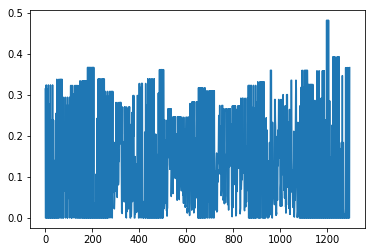

In [6]:
plt.plot(DVS_HOG[145])

In [24]:
print(np.min(EMG_TDF))
print(np.max(EMG_TDF))

0.0
68.71754309696473


# Classifications

## Create folds

In [ ]:
# singles
emg_folds = kfold(EMG_TDF, LBL, folds=10)
dvs_folds = kfold(DVS_HOG, LBL, folds=10)
dav_folds = kfold(DAV_HOG, LBL, folds=10)
frm_folds = kfold(FRM_HOG, LBL, folds=10)

fus_dvs_folds = kfold(np.hstack([EMG_TDF, DVS_HOG]), LBL, folds=10)
fus_frm_folds = kfold(np.hstack([EMG_TDF, FRM_HOG]), LBL, folds=10)
fus_dav_folds = kfold(np.hstack([EMG_TDF, DAV_HOG]), LBL, folds=10)

In [ ]:
def do_kfold_cv(folds, C=1, gamma=1, kernel='linear', normalize=True):
    all_acc_train = []
    all_acc_test = []

    for x_train, y_train, x_test, y_test in tqdm_notebook(folds):

        # normalize
        if normalize:
            _mean = np.mean(x_train, 0, keepdims=True)
            _std = np.std(x_train, 0, keepdims=True)

            x_train = (x_train - _mean) / _std
            x_test = (x_test - _mean) / _std

        svm = cv2.ml.SVM_create()
        svm.setType(cv2.ml.SVM_C_SVC)
        svm.setKernel(cv2.ml.SVM_RBF if kernel == 'rbf' else cv2.ml.SVM_LINEAR)
        svm.setC(C)
        svm.setGamma(gamma)
        svm.train(np.float32(x_train), cv2.ml.ROW_SAMPLE, np.int32(y_train))

        output = svm.predict(np.float32(x_train))
        acc = np.sum((output[1].squeeze() - y_train.squeeze()) == 0) / len(output[1])
        all_acc_train.append(acc)

        output = svm.predict(np.float32(x_test))
        acc = np.sum((output[1].squeeze() - y_test.squeeze()) == 0) / len(output[1])
        all_acc_test.append(acc)
    return all_acc_train, all_acc_test


def do_single(x_train, y_train, x_test, y_test, C=1, gamma=1, kernel='linear', norm=True, save=None):

    if norm:
        _mean = np.mean(x_train, 0, keepdims=True)
        _std = np.std(x_train, 0, keepdims=True)
        
        if save is not None:
            a = array(np.squeeze(_mean),'float32')
            output_file = open(save.replace('.xml', '.mean'), 'wb')
            a.tofile(output_file)
            output_file.close()
            
            a = array(np.squeeze(_std),'float32')
            output_file = open(save.replace('.xml', '.std'), 'wb')
            a.tofile(output_file)
            output_file.close()
        
        x_train = (x_train - _mean) / (_std + 1e-15)
        x_test = (x_test - _mean) / (_std + 1e-15)

    svm = cv2.ml.SVM_create()
    svm.setType(cv2.ml.SVM_C_SVC)
    svm.setKernel(cv2.ml.SVM_RBF if kernel == 'rbf' else cv2.ml.SVM_LINEAR)
    svm.setC(C)
    svm.setGamma(gamma)
    svm.train(np.float32(x_train), cv2.ml.ROW_SAMPLE, np.int32(y_train))

    output = svm.predict(np.float32(x_train))
    tr_acc = np.sum((output[1].squeeze() - y_train.squeeze()) == 0) / len(output[1])
    
    if save is not None:
        svm.save(save)

    output = svm.predict(np.float32(x_test))
    te_acc = np.sum((output[1].squeeze() - y_test.squeeze()) == 0) / len(output[1])
    return tr_acc, te_acc

## EMG

In [ ]:
# Train the SVM for emg
tr, te = do_single(*emg_folds[1], C=0.01, gamma=1. / 16., kernel='linear', save="lin_svm_emg.xml")
print(f"EMG only (linear): Train: {tr:.2} || Test: {te:.2}")

In [ ]:
# Train the SVM for emg
tr, te = do_single(*emg_folds[0], C=10, gamma=1. / 16., kernel='rbf')
print(f"EMG only (rbf): Train: {tr:.2} || Test: {te:.2}")

## DVS

In [ ]:
tr, te = do_single(*dvs_folds[3], C=0.001, gamma=1. / 1296, kernel='linear', save='lin_svm_dvs.xml')
print(f"DVS only (linear): Train: {tr:.2} || Test: {te:.2}")

In [ ]:
tr, te = do_single(*dvs_folds[3], C=10, gamma=1. / 1296, kernel='rbf')
print(f"DVS only (rbf): Train: {tr:.2} || Test: {te:.2}")

# DAV

In [ ]:
tr, te = do_single(*dav_folds[1], C=0.001, gamma=1. / 1296, kernel='linear', norm=True)
print(f"DAV only (linear): Train: {tr:.2} || Test: {te:.2}")

In [ ]:
tr, te = do_single(*dav_folds[1], C=0.1, gamma=1. / 1296, kernel='rbf')
print(f"DAV only (rbf): Train: {tr:.2} || Test: {te:.2}")

# FRM

In [ ]:
tr, te = do_single(*frm_folds[3], C=0.001, gamma=1. / 1296, kernel='linear')
print(f"DAV only (linear): Train: {tr:.2} || Test: {te:.2}")

In [ ]:
tr, te = do_single(*frm_folds[3], C=1, gamma=1. / 1296, kernel='rbf')
print(f"DAV only (rbf): Train: {tr:.2} || Test: {te:.2}")

# EMG + DVS

In [ ]:
tr, te = do_single(*fus_dvs_folds[3], C=0.001, gamma=1. / 1312, kernel='linear', save='lin_svm_emgdvs.xml')
print(f"DAV only (linear): Train: {tr:.2} || Test: {te:.2}")

In [ ]:
tr, te = do_single(*fus_dvs_folds[3], C=1, gamma=1. / 1312, kernel='rbf')
print(f"DAV only (rbf): Train: {tr:.2} || Test: {te:.2}")

# EMG + DAV

In [ ]:
tr, te = do_single(*fus_dav_folds[3], C=0.001, gamma=1. / 1312, kernel='linear')
print(f"DAV only (linear): Train: {tr:.2} || Test: {te:.2}")

In [ ]:
tr, te = do_single(*fus_dav_folds[3], C=1, gamma=1. / 1312, kernel='rbf')
print(f"DAV only (rbf): Train: {tr:.2} || Test: {te:.2}")

# EMG + FRM

In [ ]:
tr, te = do_single(*fus_frm_folds[3], C=0.001, gamma=1. / 1312, kernel='linear')
print(f"DAV only (linear): Train: {tr:.2} || Test: {te:.2}")

In [ ]:
tr, te = do_single(*fus_frm_folds[3], C=1, gamma=1. / 1312, kernel='rbf')
print(f"DAV only (rbf): Train: {tr:.2} || Test: {te:.2}")

# Full analysis

In [ ]:
with open(f"results_fusion_all_frame_len_linear_swipe.csv", 'w') as f:
    writer = csv.writer(f, delimiter=',')
    header = ["fold", "modality", "frame_len", "kernel", "C", "subset", "acc"]
    writer.writerow(header)
    
    for frame_len in [100, 150, 200, 250]:
        data = pkl.load(open(f"fusion_features_{frame_len}ms.pkl", "rb"))
        EMG_TDF = data['emg']
        DVS_HOG = data['dvs_evs_hog']
        FRM_HOG = data['dav_aps_hog']
        DAV_HOG = data['dav_evs_hog']
        LBL = data['lbl']
        
        emg_folds = kfold(EMG_TDF, LBL)
        frm_folds = kfold(FRM_HOG, LBL)
        dvs_folds = kfold(DVS_HOG, LBL)
        dav_folds = kfold(DAV_HOG, LBL)
        
        fus_ev_folds = kfold(np.hstack([EMG_TDF, DVS_HOG]), LBL)
        fus_da_folds = kfold(np.hstack([EMG_TDF, DAV_HOG]), LBL)
        fus_fr_folds = kfold(np.hstack([EMG_TDF, FRM_HOG]), LBL)
        
        names = ["EMG", "DVS", "DAV", "FRM", "FUS-EV", "FUS-DAV", "FUS-FR"]
        folds = [emg_folds, dvs_folds, dav_folds, frm_folds, fus_ev_folds, fus_da_folds, fus_fr_folds]
        
        
        for i, features, folds in zip(range(len(names)), names, folds):
            print(f"Features: {features} || Frame len {frame_len} ms")
            for k, (x_train, y_train, x_test, y_test) in enumerate(folds):
                for C in [10, 1, 0.1, 0.01, 0.001, 0.0001]:
                    tr_acc, te_acc = do_single(x_train, y_train, x_test, y_test, C=C, gamma=1. / x_train.shape[1], kernel='linear')
                    row = [k, features, frame_len, "linear", C, "train", tr_acc]
                    writer.writerow(row)
                    row = [k, features, frame_len, "linear", C, "test", te_acc]
                    writer.writerow(row)

                    tr_acc, te_acc = do_single(x_train, y_train, x_test, y_test, C=C, gamma=1. / x_train.shape[1], kernel='rbf')
                    row = [k, features, frame_len, "rbf", C, "train", tr_acc]
                    writer.writerow(row)
                    row = [k, features, frame_len, "rbf", C, "test", te_acc]
                    writer.writerow(row)

In [ ]:
with open(f"results_fusion_all_frame_len_linear_rbf_v2.csv", 'w') as f:
    writer = csv.writer(f, delimiter=',')
    header = ["fold", "modality", "frame_len", "kernel", "C", "subset", "acc"]
    writer.writerow(header)
    
    for frame_len in [150, 200, 250]:
        data = pkl.load(open(f"fusion_features_{frame_len}ms.pkl", "rb"))
        EMG_TDF = data['emg']
        DVS_HOG = data['dvs_evs_hog']
        FRM_HOG = data['dav_aps_hog']
        DAV_HOG = data['dav_evs_hog']
        LBL = data['lbl']
        
        emg_folds = kfold(EMG_TDF, LBL)
        frm_folds = kfold(FRM_HOG, LBL)
        dvs_folds = kfold(DVS_HOG, LBL)
        dav_folds = kfold(DAV_HOG, LBL)
        
        fus_ev_folds = kfold(np.hstack([EMG_TDF, DVS_HOG]), LBL)
        fus_da_folds = kfold(np.hstack([EMG_TDF, DAV_HOG]), LBL)
        fus_fr_folds = kfold(np.hstack([EMG_TDF, FRM_HOG]), LBL)
        
        names =    ["EMG",     "DVS",     "DAV",     "FRM",     "FUS-EV",     "FUS-DAV",    "FUS-FR"]
        folds =    [emg_folds, dvs_folds, dav_folds, frm_folds, fus_ev_folds, fus_da_folds, fus_fr_folds]
        c_linear = [0.001,     0.0001,    0.0001,    0.001,      0.001,        0.001,        0.001]
        c_rbf =    [1,         10,        10,        1,       10,           10,           10]
        
        
        for i, features, folds in zip(range(len(names)), names, folds):
            print(f"Features: {features} || Frame len {frame_len} ms")
            for k, (x_train, y_train, x_test, y_test) in enumerate(folds):
                tr_acc, te_acc = do_single(x_train, y_train, x_test, y_test, C=c_linear[i], gamma=1. / x_train.shape[1], kernel='linear')
                row = [k, features, frame_len, "linear", c_linear[i],  "train", tr_acc]
                writer.writerow(row)
                row = [k, features, frame_len, "linear", c_linear[i], "test", te_acc]
                writer.writerow(row)
                
                tr_acc, te_acc = do_single(x_train, y_train, x_test, y_test, C=c_rbf[i], gamma=1. / x_train.shape[1], kernel='rbf')
                row = [k, features, frame_len, "rbf", c_rbf[i], "train", tr_acc]
                writer.writerow(row)
                row = [k, features, frame_len, "rbf", c_rbf[i], "test", te_acc]
                writer.writerow(row)

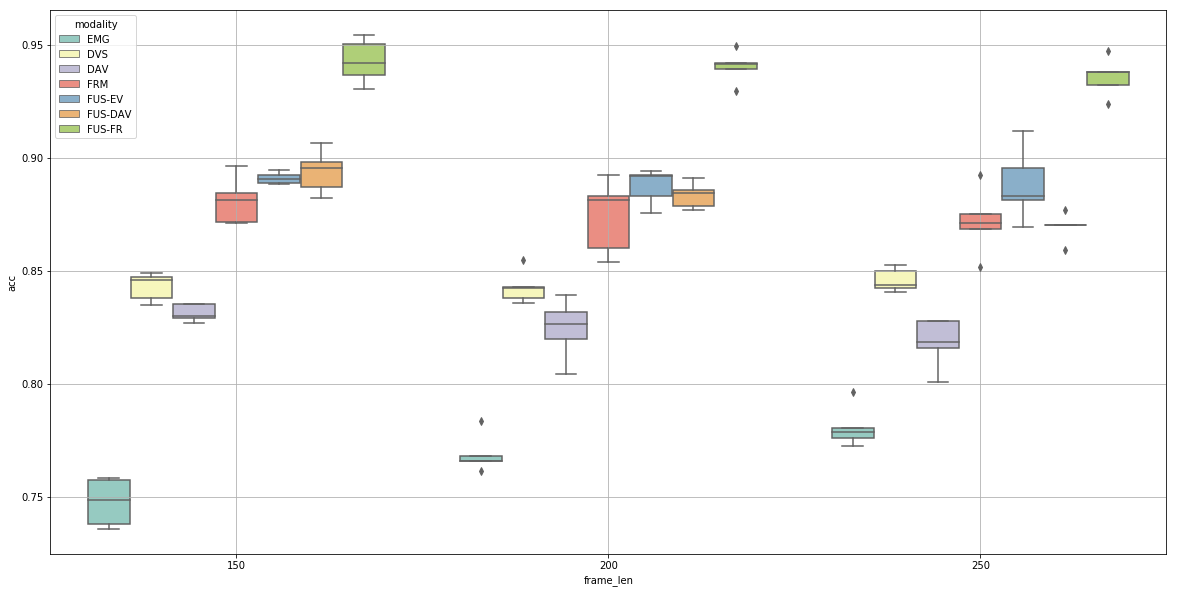

In [26]:
data = pd.read_csv("results/results_fusion_all_frame_len_linear_rbf_v2.csv")

plt.figure(figsize=(20,10))
df = data[data["subset"] == "test"]
df = df[df["kernel"] == "rbf"]
# df = df[df["frame_len"] == 100]
x = 'frame_len'
y = 'acc'
hue = 'modality'
ax = sns.boxplot(x=x, y=y, data=df, hue=hue, palette="Set3")
ax.grid()

In [36]:
df = data[data["subset"] == "test"]
df = df[df["kernel"] == "rbf"]
df = df[df["frame_len"] == 200]
df = df[["modality", "acc"]]
df.groupby(["modality"]).std() * 100



,acc
modality,
DAV,1.321968
DVS,0.745540
EMG,0.854906
FRM,1.639198
FUS-DAV,0.572818
FUS-EV,0.792627
FUS-FR,0.719320
